///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////                    

                                KRISSAAN AMEN ALLAH - M2 -TRIED                   

                                amenallahkrissane10@gmail.com                   

                            amen-allah.krissaan@telecom-sudparis.eu 
                            
                                        Lab 4- DEEP RN          

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# TP 4.1 - Auto-encodeurs variationnels
## Cahier Jupyter

L’objectif de cette séance de travaux pratiques est d’illustrer la construction d’un espace latent en utilisant un auto-encodeur classique, puis un auto-encodeur variationnel (cf. Kingma et Welling).

Nous utiliserons ensuite le VAE pour générer des données synthétiques mais plausibles vis à vis de la distribution des données d’apprentissage.

Le TP est dimensionné de sorte à pouvoir être terminé sans accélérateur graphique pour les calculs en utilisant la base de données Fashion-MNIST. Si vous disposez d’un GPU (par exemple, parce que vous travaillez sur Google Colab), vous pouvez changer la valeur de la variable `use_gpu` à `True`.

In [86]:
import torch
use_gpu = False
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(f"Exécution sur {device}")

# Imports des bibliothèques utiles
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt




Exécution sur cpu


## Préambule
Pour commencer, nous allons charger en mémoire les données de Fashion-MNIST et en visualiser quelques unes. Ces images sont similaires en format aux données de MNIST : 28x28 pixels en niveaux de gris.

Ce jeu de données est préintégré dans la bibliothèque `torchvision`:

In [87]:
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, ToPILImage

train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=ToTensor())
test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=ToTensor())

Nous pouvons visualiser quelques unes de ces images:

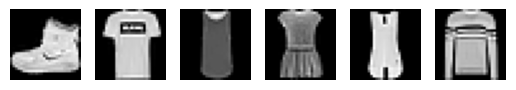

In [88]:
n_images = 5

fig = plt.figure()
for i, (image, label) in enumerate(train_dataset):
    fig.add_subplot(1, n_images+1, i+1)
    plt.imshow(ToPILImage()(image), cmap="gray")
    plt.axis("off")
    if i >= n_images:
        break
plt.show()

## Auto-encodeur
### Implémentation
Notre premier modèle sera un auto-encodeur convolutif doté de l’architecture ci-dessous.

Pour l’encodeur :
- une couche de convolution (`kernel_size=4`, `in_channels=1`, `out_channels=32`, `stride=2`, `padding=1`, activation ReLU)
- une couche de convolution (`kernel_size=4`, `in_channels=32`, `out_channels=64`, `stride=2`, `padding=1`, activation ReLU)
- une couche linéaire (`in_features=64*7*7`, `out_features=latent_dimension`)

Pour le décodeur:
- une couche linéaire (`in_features=latent_dimension`, `out_features=64*7*7`, activation ReLU)
- une couche de convolution transposée (`kernel size=4`, `in_channels=64`, `out_channels=32`, `stride=2`, `padding=1`, activation ReLU)
- une couche de convolution transposée (`kernel size=4`, `in_channels=32`, `out_channels=1`, `stride=2`, `padding=1`, activation sigmoide)

**Note**
Les filtres convolutifs sont choisis de taille 4x4 afin d’éviter des problèmes d’aliasing.

**Question**
Compléter l’implémentation ci-dessous de l’auto-encodeur dont l’architecture vient d’être décrite. Cette implémentation utilise l’interface `torch.nn.Module` dont la documentation peut vous être utile.

En plus de la reconstruction par l’auto-encodeur, on souhaite que la méthode `forward()` renvoie également le code intermédiaire `z` (un vecteur de longueur `latent_dimension`) obtenu après le passage dans le décodeur.

**Indice**: l’utilisation de la méthode `.view()` ou de la couche `nn.Flatten()` peut être utile pour ré-arranger les tenseurs avant ou après les couches linéaires. Par exemple, `x.view(-1, 64, 7, 7)` permet de transformer un tenseur de dimensions `(batch, 3136)` en un tenseur de dimensions `(batch, 64, 7, 7)`

In [89]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dimension):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dimension)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dimension, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        hat_x = self.decoder(z)
        return hat_x, z

### Entraînement
Une fois le modèle implémenté, nous pouvons utiliser la fonction `train` ci-dessous pour réaliser l’apprentissage. L’optimisation se fait selon le critère choisi dans la variable `criterion` (par défaut, il s’agit de l’erreur quadratique moyenne comme critère de reconstruction).

In [90]:
from tqdm.notebook import trange, tqdm

def train(net, train_dataset, epochs=10, learning_rate=1e-3, batch_size=128, device=device):
    # Création du DataLoader pour charger les données
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    # Définition de l'algorithme d'optimisation (Adam, variante de la SGD)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=1e-5)
    # Choix de la fonction de coût
    criterion = nn.MSELoss()
    # Passe le modèle en mode "apprentissage"
    net = net.to(device)
    net = net.train()

    train_loss_avg = []

    t = trange(1, epochs + 1, desc="Entraînement du modèle")
    for epoch in t:
        avg_loss = 0.
        # Parcours du dataset pour une epoch
        for images, _ in tqdm(train_dataloader):
            # les labels sont ignorés pour l'apprentissage de l'auto-encodeur

            images = images.to(device)
            # Calcul de la reconstruction
            reconstructions, _ = net(images)
            # Calcul del'erreur
            loss = criterion(reconstructions, images)

            # Rétropropagation du gradient
            optimizer.zero_grad()
            loss.backward()
            # Descente de gradient (une itération)
            optimizer.step()
            avg_loss += loss.item()

        avg_loss /= len(train_dataloader)
        t.set_description(f"Epoch {epoch}: loss = {avg_loss:.3f}")
    return net

Nous pouvons créer un modèle en spécifiant la dimension de son espace latent (par exemple, 10):

In [91]:
latent_dimension = 10
net = AutoEncoder(latent_dimension)

Puis démarrer son entraînement (sur CPU, cette opération peut prendre jusqu’à une dizaine de minutes) :

In [92]:
net = train(net, train_dataset)

Entraînement du modèle:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

### Visualisation des reconstructions
Une fois l’apprentissage terminé, nous pouvons visualiser quelques reconstructions obtenues grâce à l’auto-encodeur. Cela permet de jauger qualitativement des performances du modèle en reconstruction.

**Note**
La compréhension fine des fonctions `make_grid`, `show_grid` et `visualize_reconstructions` n’est pas indispensable à la poursuite du TP.

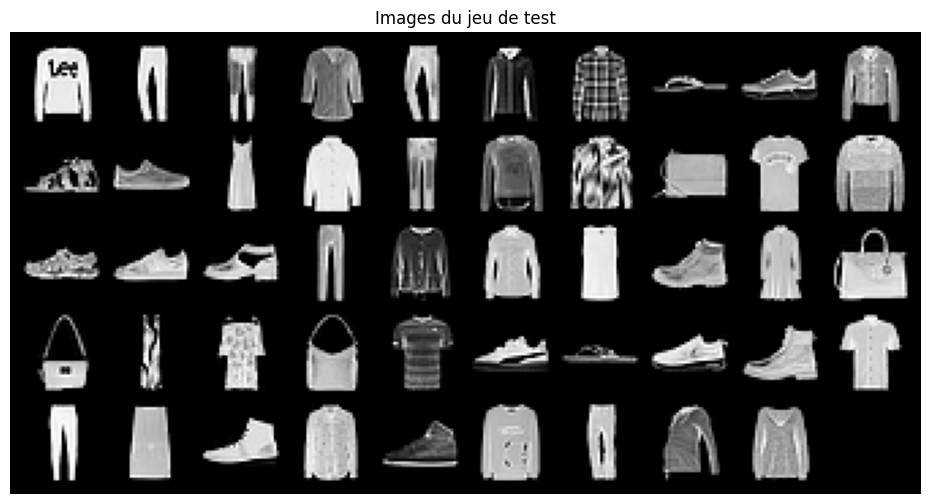

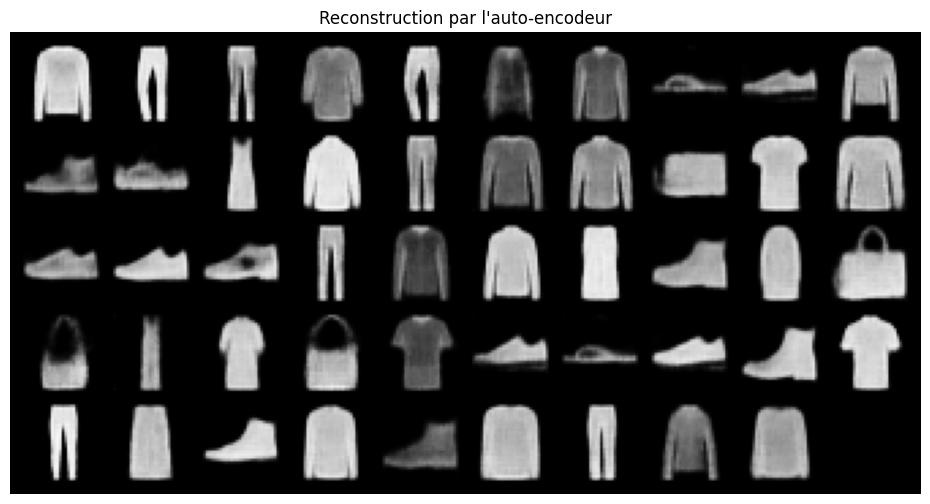

In [93]:
from torchvision.utils import make_grid

net = net.eval()
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

def show_grid(grid):
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

def visualize_reconstructions(net, images, device=device):
    # Mode inférence
    with torch.no_grad():
        images = images.to(device)
        reconstructions = net(images)[0]
        image_grid = make_grid(reconstructions[1:50], nrow=10, padding=5).cpu()
        return image_grid

# Use the next() function to get the next item from the iterator
images, _ = next(iter(test_dataloader))
# Images de test
plt.figure(figsize=(12, 6))
plt.title("Images du jeu de test")
show_grid(make_grid(images[1:50], nrow=10, padding=5))

# Reconstruction et visualisation des images reconstruites
plt.figure(figsize=(12, 6))
plt.title("Reconstruction par l'auto-encodeur")
show_grid(visualize_reconstructions(net, images))

### Débruitage
Une capacité intéressante des auto-encodeurs est leur capacité à apprendre des filtres robustes au bruit. En particulier, en bruitant légèrement une observation, on retrouve généralement la reconstruction moyenne non-bruitée. Cette propriété de débruitage est particulièrement intéressante pour l’amélioration de la qualité des signaux (images, sons, etc.).

Observons la capacité de débruitage de notre auto-encodeur sur un échantillon d’images de test.

**Question**
Compléter le code ci-dessous pour ajouter un bruit blanc uniforme aux images de test contenues dans le tenseur `images`. Pensez à ajuster l’amplitude du bruit et à limiter les valeurs des pixels de sortie à la plage autorisée `[0,1]` (la fonction `clamp` peut vous aider).

In [94]:
noise = torch.randn_like(images) * 0.1 # Adding Gaussian noise with standard deviation of 0.1
noisy_images = torch.clamp(images + noise, 0., 1.) # Clamping the values to be within [0, 1]

Nous pouvons alors visualiser la reconstruction des images bruitées.

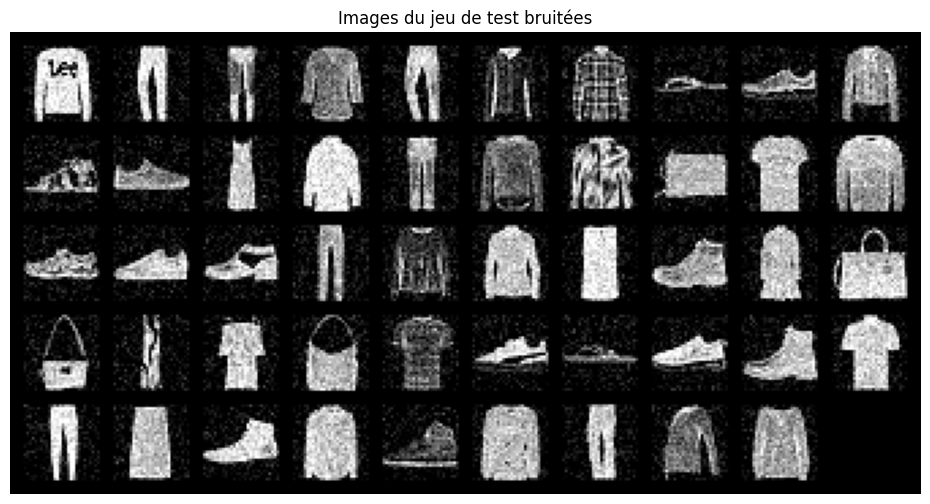

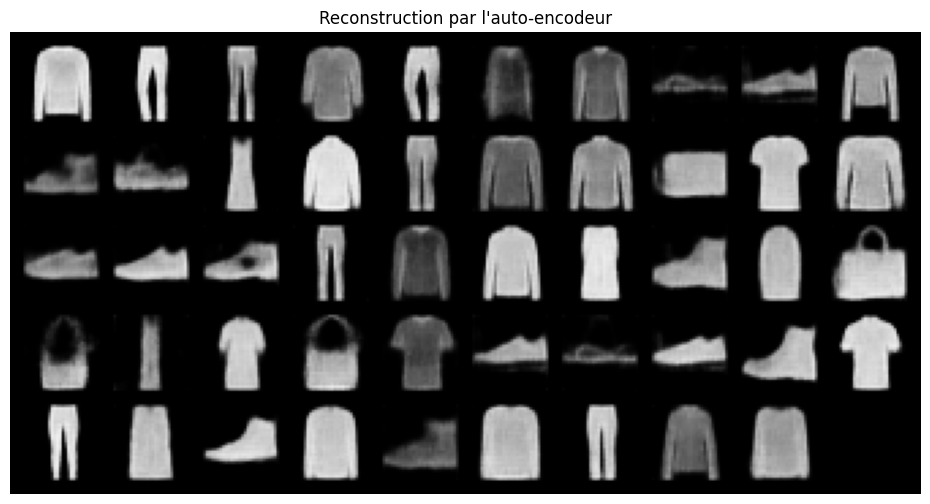

In [95]:
# Images de test
plt.figure(figsize=(12, 6))
plt.title("Images du jeu de test bruitées")
show_grid(make_grid(noisy_images[1:50],10,5))

# Reconstruction et visualisation des images reconstruites
plt.figure(figsize=(12, 6))
plt.title("Reconstruction par l'auto-encodeur")
show_grid(visualize_reconstructions(net, noisy_images))

**Question**
Comparer les reconstructions des images bruitées aux reconstructions obtenues sur les images de test originales. Que constatez-vous ?

---

### **Observations :**

1. **Images bruitées :**
   - Les images bruitées présentent des perturbations visibles, comme des pixels aléatoires ou des distorsions.
   - Ces perturbations peuvent rendre les images difficiles à interpréter pour un humain.

2. **Reconstructions des images bruitées :**
   - L'auto-encodeur parvient à reconstruire des images relativement propres à partir des images bruitées.
   - Les reconstructions montrent que l'auto-encodeur a appris à ignorer une partie du bruit et à restaurer les caractéristiques principales des images.

3. **Reconstructions des images originales :**
   - Les reconstructions des images originales sont généralement de meilleure qualité que celles des images bruitées.
   - L'auto-encodeur reproduit fidèlement les détails des images originales, avec peu ou pas de distorsions.



### **Comparaison :**

- **Qualité des reconstructions :**
  - Les reconstructions des images originales sont plus nettes et plus précises que celles des images bruitées.
  - Les reconstructions des images bruitées montrent que l'auto-encodeur est capable de "débruiter" les images, mais avec une perte de détails par rapport aux reconstructions des images originales.

- **Capacité de débruitage :**
  - L'auto-encodeur démontre une capacité à réduire le bruit et à restaurer les caractéristiques principales des images.
  - Cependant, certaines distorsions ou artefacts peuvent persister dans les reconstructions des images bruitées.

---

### **Conclusion :**

L'auto-encodeur est efficace pour reconstruire des images à partir de données bruitées, mais les reconstructions sont de moindre qualité par rapport à celles obtenues à partir d'images originales. Cela montre que l'auto-encodeur a appris à extraire les caractéristiques essentielles des images tout en étant robuste à un certain niveau de bruit. Cependant, la présence de bruit affecte la précision des reconstructions, ce qui est attendu étant donné la nature du problème de débruitage.


---
---

## Auto-encodeurs variationnels
### Implémentation
Nous allons à présent implémenter un VAE convolutif qui hérite de la même structure que l’auto-encodeur que nous avons précédemment défini. Pour nous simplifier les choses par la suite, nous allons commencer par séparer le sous-réseau qui définit l’encodeur de celui qui définit le décodeur.

**Question**: en reprenant ce qui a été fait plus haut pour l’auto-encodeur classique, compléter les implémentations ci-dessous de l’encodeur et du décodeur pour le VAE. On rappelle que, contrairement à l’auto-encodeur, la sortie de l’encodeur est double :
- le vecteur `mu` qui contient la moyenne de la gaussienne dans l’espace latent,
- le vecteur `sigma` qui contient les variances selon les différentes directions de la gaussienne dans l’espace latent.

Ces valeurs seront les paramètres de la gaussienne associée à une observation `x`. Ces deux vecteurs ont pour dimension la dimension de l’espace latent.

In [96]:
class Encoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Encoder, self).__init__()
        # Couches convolutives
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # 14x14 -> 7x7
        # Couches linéaires pour mu et logvar
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dimension)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dimension)
        # Fonctions d'activation
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        # Passage à travers les couches convolutives
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        # Aplatir le tenseur
        x = self.flatten(x)
        # Calcul de mu et logvar
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Decoder, self).__init__()
        # Couche linéaire pour passer de l'espace latent à 64*7*7
        self.fc = nn.Linear(latent_dimension, 64 * 7 * 7)
        # Couches convolutives transposées
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # 7x7 -> 14x14
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)    # 14x14 -> 28x28
        # Fonctions d'activation
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # Passage à travers la couche linéaire
        z = self.relu(self.fc(z))
        # Redimensionner en [batch_size, 64, 7, 7]
        z = z.view(-1, 64, 7, 7)  # Utilisation de view au lieu de Unflatten
        # Passage à travers les couches convolutives transposées
        z = self.relu(self.deconv1(z))
        hat_x = self.sigmoid(self.deconv2(z))  # Activation sigmoïde pour les pixels entre 0 et 1
        return hat_x

Nous allons à présent combiner l’encodeur et le décodeur pour former l’auto-encodeur variationnel complet. Il y a néanmoins une petite subtilité car nous devons implémenter l’astuce de reparamétrisation. Celle-ci est implémenter dans la méthode `latent_sample`

Lors d’un passage avant (`forward`), le schéma suivant doit se dérouler :
- L’encodeur prend `x` en entrée et produit la moyenne `mu` et la variance `logvar` de la distribution. En pratique, on verra aussi `x_recon` la reconstruction de `x`.
- On tire un échantillon aléatoire `z` dans l’espace latent à l’aide de la méthode `latent_sample`. L’échantillonnage est fait selon la distribution gaussienne latente associée à `x` grâce à la reparamétrisation. Lors de l’inférence, on ne réalisera pas d’échantillonnage mais on se contentera d’utiliser la moyenne de la gaussienne.
- L’échantillon aléatoire `z` est passé dans le décodeur de sorte à obtenir la reconstruction `x_recon`.

**Question**
Compléter l’implémentation ci-dessous de l’auto-encodeur variationnel.

In [97]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dimension):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dimension)
        self.decoder = Decoder(latent_dimension)

    def forward(self, x):
        # Encoder : obtenir mu et logvar
        mu, logvar = self.encoder(x)
        # Échantillonnage dans l'espace latent
        z = self.latent_sample(mu, logvar)
        # Decoder : reconstruire l'image
        hat_x = self.decoder(z)
        return hat_x, mu, logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # Astuce de reparamétrisation
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            # En mode inférence, utiliser directement mu
            return mu

Enfin, il reste à définir la fonction de coût du VAE. D’après le cours, on cherche à maximiser l’ELBO `L`. Ici, on choisira de minimiser `-L` avec

$$
L(θ,ϕ;x)=Eqϕ(z|x)[logpθ(x|z)] - KL(qϕ(z|x)||pθ(z))
$$

La fonction de coût pour une reconstruction sur une seule donnée `x(i)` est approximée par:

$$
-L(θ,ϕ;x(i))≃-12∑jd(1+log((σ(i)j)2)−(μ(i)j)2−(σ(i)j)2)−logpθ(x(i)|z(i))
$$

où `d` est la taille de l’espace latent.

**Note**
Dans la plupart des cas, la vraisemblance est supposée gaussienne et la fonction de coût évaluant la reconstruction correspondra donc à l’erreur quadratique moyenne (`F.mse_loss()`). Dans notre cas, la distribution des valeurs des pixels de Fashion-MNIST est plutôt bimodale. Les images étant à valeurs entre 0 et 1, il est possible d’utiliser une entropie croisée binaire (`F.bce_loss()`) et c’est cette version qui donne les meilleurs résultats.

Le prior `pθ(z)` est supposé être donné par une loi normale centrée réduite. La divergence de Kullback-Leibler est alors donnée par:

$$
KL(qϕ(z|x)||pθ(z))=12(tr(σI)+μTμ−k−logdet(σI))
$$

**Question**
Modifier la fonction `vae_loss()` ci-dessous de sorte à calculer la fonction de coût du `β`-auto-encodeur variationnel (on souhaite pouvoir changer `β` facilement plus tard si besoin).

In [98]:
def vae_loss(hat_x, x, mu, logvar, beta=1.0):
    # Perte de reconstruction (entropie croisée binaire)
    reconstruction_loss = F.binary_cross_entropy(hat_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    # Divergence de Kullback-Leibler
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Combinaison des deux termes
    return reconstruction_loss + beta * kl_divergence

### Entraînement
Ce travail effectué, nous disposons du modèle, de la fonction objectif et des données. Il ne reste plus qu’à réaliser l’apprentissage du VAE.

In [99]:
from tqdm.notebook import trange, tqdm

def train_vae(net, train_dataset, epochs=10, learning_rate=1e-3, batch_size=128, device=device):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)
    net = net.to(device)
    net = net.train()

    for epoch in range(epochs):
        avg_loss = 0.
        for images, _ in train_dataloader:
            images = images.to(device)
            # Forward pass
            reconstructions, mu, logvar = net(images)
            # Calcul de la perte
            loss = vae_loss(reconstructions, images, mu, logvar)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

        avg_loss /= len(train_dataloader)
        print(f"Epoch {epoch + 1}: loss = {avg_loss:.3f}")
    return net.to("cpu")

In [100]:
latent_dim = 10
vae = VariationalAutoencoder(latent_dim)
vae = train_vae(vae, train_dataset, epochs=20)

Epoch 1: loss = 37272.298
Epoch 2: loss = 32138.538
Epoch 3: loss = 31682.054
Epoch 4: loss = 31426.253
Epoch 5: loss = 31267.654
Epoch 6: loss = 31156.952
Epoch 7: loss = 31064.153
Epoch 8: loss = 30989.694
Epoch 9: loss = 30935.145
Epoch 10: loss = 30884.948
Epoch 11: loss = 30834.890
Epoch 12: loss = 30811.243
Epoch 13: loss = 30773.373
Epoch 14: loss = 30747.787
Epoch 15: loss = 30716.483
Epoch 16: loss = 30692.198
Epoch 17: loss = 30675.671
Epoch 18: loss = 30657.169
Epoch 19: loss = 30636.389
Epoch 20: loss = 30617.316


**Question**
Créer un modèle de VAE et lancer son apprentissage à l’aide de la fonction `train_vae` ci-dessus.

### Visualisation des reconstruction
Comme dans le cas de l’auto-encodeur classique, nous pouvons visualiser quelques reconstructions pour juger qualitativement des performances du modèle.

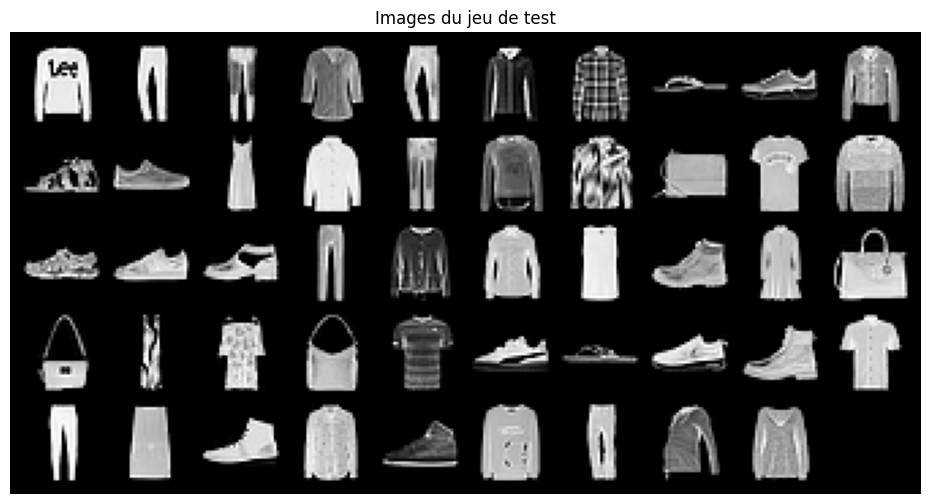

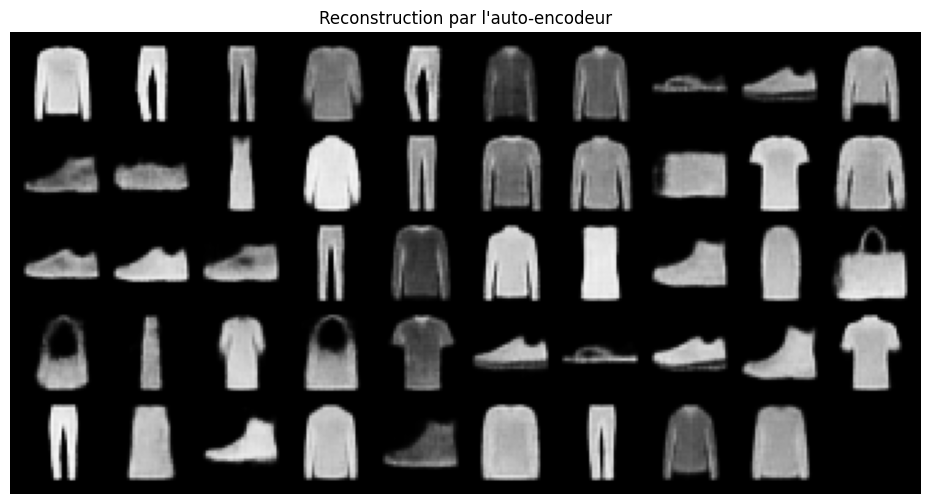

In [101]:
vae = vae.to("cpu")
images, _ = next(iter(test_dataloader))

# Images de test
plt.figure(figsize=(12, 6))
plt.title("Images du jeu de test")
show_grid(make_grid(images[1:50],10,5))

# Reconstruction et visualisation des images reconstruites
plt.figure(figsize=(12, 6))
plt.title("Reconstruction par l'auto-encodeur")
show_grid(visualize_reconstructions(vae, images))

### Echantillonnage dans l’espace latent
Un VAE peut générer de nouvelles données à partir de vecteur tirés dans l’espacee latent. Plus le poids donné à la KL-divergence est important (`β` élevé), plus cet espace est “rempli”, au sens où la distribution de l’espace latent se rapproche d’une loi normale centrée réduite. Cette capacité d’interpolation augmentée vient en contrepartie de reconstructions pouvant être de significativement moins bonne qualité que des auto-encodeurs classiques.

**Question**
Échantillonner quelques vecteurs dans l’espace latent selon une loi centrée réduite. Décoder ces vecteurs pour obtenir des nouvelles images synthétiques. Vous pouvez passer par l’attribut `.decoder` de l’objet VAE pour accéder directement au décodeur.

In [102]:
# Générer des échantillons
def generate_samples(vae, n_samples=10, latent_dim=10):
    z = torch.randn(n_samples, latent_dim)
    with torch.no_grad():
        samples = vae.decoder(z)
    return samples

# Interpolation entre deux vecteurs latents
def interpolate(vae, z1, z2, n_steps=10):
    alphas = torch.linspace(0, 1, n_steps)
    interpolated_samples = []
    for alpha in alphas:
        z = alpha * z1 + (1 - alpha) * z2
        with torch.no_grad():
            sample = vae.decoder(z.unsqueeze(0))  # Ajouter une dimension de batch
        interpolated_samples.append(sample)
    return torch.cat(interpolated_samples)

# Exemple d'utilisation
z1 = torch.randn(1, latent_dimension)
z2 = torch.randn(1, latent_dimension)
interpolated_samples = interpolate(vae, z1, z2, n_steps=10)

### Interpolation dans l’espace latent
Comme pour l’auto-encodeur classique, il est possible d’interpoler entre deux vecteurs arbitraires dans l’espace latent. Pour un auto-encodeur normal, cette interpolation produit rarement des images plausibles car l’espace latent est discontinu et contient de nombreux “trous”. En revanche, ce n’est pas le cas du VAE grâce au prior gaussien.

**Question**
Interpoler entre deux vecteurs aléatoires dans l’espace latent et visualiser le résultat (par exemple, 10 images sur le segment entre `z1` et `z2`).

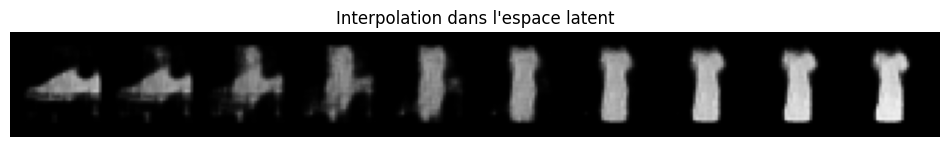

In [103]:
def interpolate(vae, z1, z2, n_steps=10):
    # Interpolation linéaire entre z1 et z2
    alphas = torch.linspace(0, 1, n_steps)
    interpolated_samples = []
    for alpha in alphas:
        z = alpha * z1 + (1 - alpha) * z2
        with torch.no_grad():
            sample = vae.decoder(z.unsqueeze(0))  # Ajouter une dimension de batch
        interpolated_samples.append(sample)
    return torch.cat(interpolated_samples)

# Générer deux vecteurs latents aléatoires
z1 = torch.randn(1, latent_dim)
z2 = torch.randn(1, latent_dim)

# Interpolation et visualisation
interpolated_samples = interpolate(vae, z1, z2, n_steps=10)
plt.figure(figsize=(12, 6))
plt.title("Interpolation dans l'espace latent")
show_grid(make_grid(interpolated_samples, 10, 5))

### Visualisation de l’espace latent
Nous pouvons comparer l’espace latent de l’auto-encodeur classique et celui de l’auto-encodeur variationnel, par exemple à l’aide de t-SNE pour projeter les codes latents du jeu de test sur un plan en deux dimensions.

**Question**
(optionnel, pour l’approfondissement) Pour toutes les images du jeu de test de Fashion-MNIST, calculer le code latent associé (on prendra la moyenne de la distribution dans le cas du VAE). Appliquer une réduction de dimension non-linéaire en utilisant la version de t-SNE disponible dans scikit-learn pour projeter les codes latents dans le plan. Coloriez les points en fonction de leur catégorie dans le jeu de données.

Que constatez-vous ? Que se passe-t-il si l’on refait l’expérience avec une valeur plus élevée pour `β` dans le VAE ? Avec une valeur plus faible ?

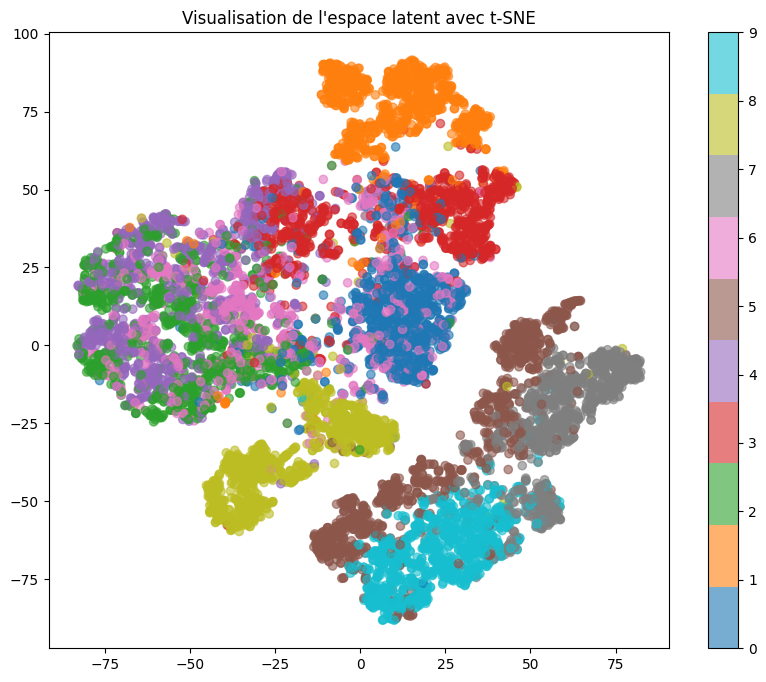

In [104]:
from sklearn.manifold import TSNE

def visualize_latent_space(vae, test_dataset, latent_dim=10):
    test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    latent_vectors = []
    labels = []

    # Extraire les vecteurs latents pour toutes les images de test
    with torch.no_grad():
        for images, label in test_dataloader:
            mu, _ = vae.encoder(images)
            latent_vectors.append(mu)
            labels.append(label)

    latent_vectors = torch.cat(latent_vectors).numpy()
    labels = torch.cat(labels).numpy()

    # Réduction de dimension avec t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    # Visualisation
    plt.figure(figsize=(10, 8))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar()
    plt.title("Visualisation de l'espace latent avec t-SNE")
    plt.show()

# Appeler la fonction
visualize_latent_space(vae, test_dataset)

--------------
-------------


# TP 4.2 - VAE conditionnel et PixelCNN
## Cahier Jupyter

L’objectif de cette séance de travaux pratiques est d’utiliser d’une part la génération conditionnée de chiffres à l’aide d’un autoencodeur variationnel conditionnel et d’autre part d’illustrer la mise en œuvre d’un modèle autorégressif sur des images, en l’occurrence PixelCNN.

## Préambule
Comme les semaines passées, nous pouvons commencer par importer quelques bibliothèques utiles (Matplotlib, NumPy et PyTorch).

In [105]:
# Import des bibliothèques utiles
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

Il est préférable d’utiliser une machine dotée d’une carte graphique (GPU) pour ce TP afin d’accélérer les calculs et ne pas devoir patienter trop longtemps lors de l’entraînement des modèles.

In [106]:
# Utilise la carte graphique (si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## VAE conditionnel
Pour commencer, nous allons implémenter un autoencodeur variationnel conditionnel en nous inspirant du VAE que nous avons écrit lors du précédent TP. À titre d’illustration, nous allons expérimenter avec la base de données MNIST qui contient des chiffres manuscrits étiquetés de 0 à 9.

In [107]:
from torchvision.transforms import ToTensor, ToPILImage
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=ToTensor())
test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=ToTensor())

On souhaite dans notre cas conditionner le modèle au chiffre représenté par l’image. Cette information correspond dans le jeu de données à une étiquette sous la forme d’un entier de 0 à 9, que l’on représentera plus tard sous la forme d’un vecteur en encodage one-hot, c’est-à-dire : [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] pour l’étiquette 6.

La longueur du vecteur de conditionnement est donc 10 (le nombre de classes du jeu de données).

In [108]:
num_classes = 10

### Question : Implémentation de l'encodeur et du décodeur
Reprendre le code du VAE du TP précédent et l’adapter de sorte à ce que :
- l’encodeur accepte le vecteur de conditionnement comme deuxième argument dans la méthode `.forward()`.
- le décodeur accepte le vecteur de conditionnement comme deuxième argument dans la méthode `.forward()`.

**Indice :** Utilisez `torch.cat()` pour concaténer le vecteur de conditionnement aux features.

In [109]:
import torch.nn as nn
import torch.nn.functional as F
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(64 * 7 * 7 + 10, latent_dim)  # +10 for one-hot labels
        self.fc_logvar = nn.Linear(64 * 7 * 7 + 10, latent_dim)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x, c):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = torch.cat([x, c], dim=1)  # Concatenate condition
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim + 10, 64 * 7 * 7)  # +10 for one-hot labels
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.unflatten = nn.Unflatten(1, (64, 7, 7))

    def forward(self, z, c):
        z = torch.cat([z, c], dim=1)  # Concatenate condition
        z = self.relu(self.fc(z))
        z = self.unflatten(z)
        z = self.relu(self.deconv1(z))
        hat_x = self.sigmoid(self.deconv2(z))
        return hat_x

### Question : Implémentation du VAE conditionnel
Modifier l’implémentation de l’autoencodeur variationnel pour inclure le conditionnement.

In [110]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.latent_sample(mu, logvar)
        hat_x = self.decoder(z, c)
        return hat_x, mu, logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

### Entraînement du VAE conditionnel
La boucle d’apprentissage ne change presque pas par rapport au TP précédent : il suffit d’encoder les étiquettes dans le format one-hot et de les fournir au VAE au moment du calcul de la reconstruction.

In [111]:
from tqdm.notebook import trange, tqdm

def vae_loss(hat_x, x, mu, logvar):
    reconstruction_loss = F.binary_cross_entropy(hat_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

def train_vae(net, train_dataset, epochs=10, learning_rate=1e-3, batch_size=32, device=device):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=1e-5)
    net = net.to(device)
    net = net.train()

    t = trange(1, epochs + 1, desc="Entraînement du modèle")
    for epoch in t:
        avg_loss = 0.
        for images, labels in tqdm(train_dataloader):
            images = images.to(device)
            labels = F.one_hot(labels, num_classes=10).float().to(device)

            reconstructions, mu, logvar = net(images, labels)
            loss = vae_loss(reconstructions, images, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

        avg_loss /= len(train_dataloader)
        t.set_description(f"Epoch {epoch}: loss = {avg_loss:.3f}")
    return net.to("cpu").eval()

### Entraînement du VAE conditionnel
Nous pouvons ainsi entraîner notre VAE conditionnel sur la base de données MNIST :

In [112]:
# Load MNIST dataset
train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=ToTensor())

# Initialize and train the VAE
vae = VariationalAutoencoder(latent_dim=10)
vae = train_vae(vae, train_dataset)

Entraînement du modèle:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Générer et visualiser des chiffres de différentes classes en échantillonnant dans la distribution conditionnelle. Le code latent est toujours échantillonné selon une loi normale 
N(0,I) , seul le vecteur de conditionnement change.

### Question : Génération conditionnelle
Générer et visualiser des chiffres de différentes classes en échantillonnant dans la distribution conditionnelle.

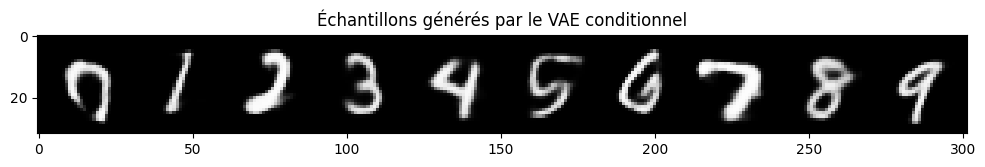

In [123]:
def generate_samples(vae, n_samples=10, latent_dim=10):
    z = torch.randn(n_samples, latent_dim)
    labels = torch.arange(0, 10).long()
    labels = F.one_hot(labels, num_classes=10).float()
    with torch.no_grad():
        samples = vae.decoder(z, labels)
    return samples

# Generate and display samples
samples = generate_samples(vae, n_samples=10)
plt.figure(figsize=(12, 6))
plt.title("Échantillons générés par le VAE conditionnel")
plt.imshow(make_grid(samples, nrow=10).permute(1, 2, 0))
plt.show()

Générer et visualiser des chiffres de différentes classes en échantillonnant dans la distribution conditionnelle. Le code latent est toujours échantillonné selon une loi normale  N(0,I) , seul le vecteur de conditionnement change.

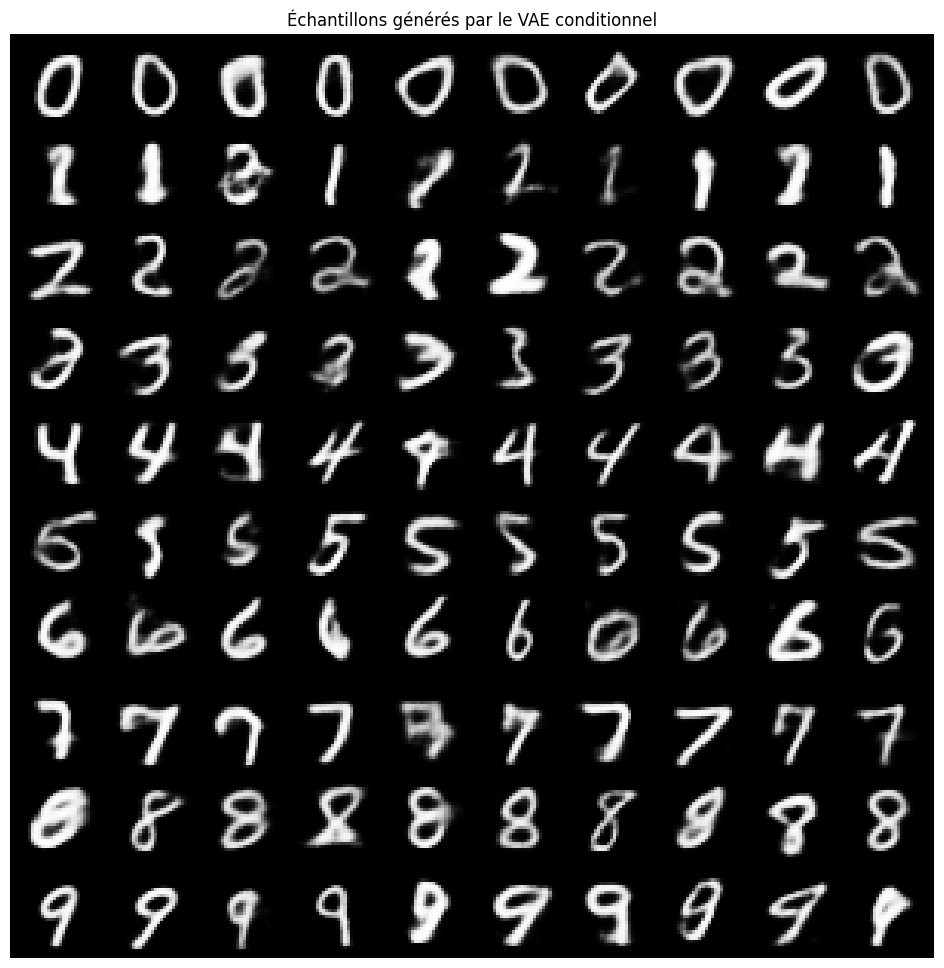

In [125]:
def generate_conditional_samples(vae, num_classes=10, latent_dim=10, num_samples_per_class=10):
    vae = vae.to(device)
    vae.eval()
    
    samples = []
    for label in range(num_classes):
        z = torch.randn(num_samples_per_class, latent_dim).to(device)
        labels = torch.tensor([label] * num_samples_per_class).to(device)
        labels_one_hot = F.one_hot(labels, num_classes=num_classes).float().to(device)
        
        with torch.no_grad():
            generated_images = vae.decoder(z, labels_one_hot)
            samples.append(generated_images.cpu())
    
    samples = torch.cat(samples)
    return samples

# Generate and visualize samples
conditional_samples = generate_conditional_samples(vae, num_classes=num_classes, latent_dim=latent_dim, num_samples_per_class=10)

plt.figure(figsize=(12, 12))
plt.title("Échantillons générés par le VAE conditionnel")
plt.imshow(make_grid(conditional_samples, nrow=num_samples_per_class).permute(1, 2, 0))
plt.axis('off')
plt.show()

## PixelCNN
### Question : Implémentation de PixelCNN
Implémenter le modèle PixelCNN en utilisant des convolutions masquées.

In [134]:
class MaskedConvolution(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConvolution, self).__init__(*args, **kwargs)
        assert mask_type in ['A', 'B'], "Unknown Mask Type"
        self.mask_type = mask_type
        self.register_buffer('mask', self.weight.data.clone())
        _, depth, height, width = self.weight.size()
        self.mask.fill_(1)

        if mask_type == 'A':
            self.mask[:, :, height // 2, width // 2:] = 0
            self.mask[:, :, height // 2 + 1:, :] = 0
        elif mask_type == 'B':
            self.mask[:, :, height // 2, width // 2 + 1:] = 0
            self.mask[:, :, height // 2 + 1:, :] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConvolution, self).forward(x)

class PixelCNN(nn.Module):
    def __init__(self, classes=256, channels=64):
        super(PixelCNN, self).__init__()
        self.conv1 = MaskedConvolution('A', 1, channels, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()

        self.conv_layers = nn.ModuleList()
        for _ in range(7):
            self.conv_layers.append(MaskedConvolution('B', channels, channels, kernel_size=3, stride=1, padding=1))
            self.conv_layers.append(nn.BatchNorm2d(channels))
            self.conv_layers.append(nn.ReLU())

        self.conv_final = nn.Conv2d(channels, classes, kernel_size=1)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        for layer in self.conv_layers:
            x = layer(x)
        x = self.conv_final(x)
        return x

### Entraînement de PixelCNN
Entraîner le modèle PixelCNN sur FashionMNIST.

In [135]:

from tqdm.notebook import trange, tqdm

def train(net, train_dataset, epochs=5, learning_rate=1e-3, batch_size=32, device=device):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    net = net.to(device)
    net = net.train()

    t = trange(1, epochs + 1, desc="Entraînement du modèle")
    for epoch in t:
        avg_loss = 0.
        for images, _ in tqdm(train_dataloader):
            images = images.to(device)
            target = (images[:, 0] * 255).long().to(device)

            reconstructions = net(images)
            loss = F.cross_entropy(reconstructions, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            t.set_description(f"Epoch {epoch}: loss = {loss.item():.3f}")

        avg_loss /= len(train_dataloader)
        t.set_description(f"Epoch {epoch}: loss = {avg_loss:.3f}")
    return net.eval()

net = PixelCNN()
net = train(net, train_dataset)

Entraînement du modèle:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

### Question : Génération d'images avec PixelCNN
Parcourir l’image synthétique pour la remplir pixel par pixel.

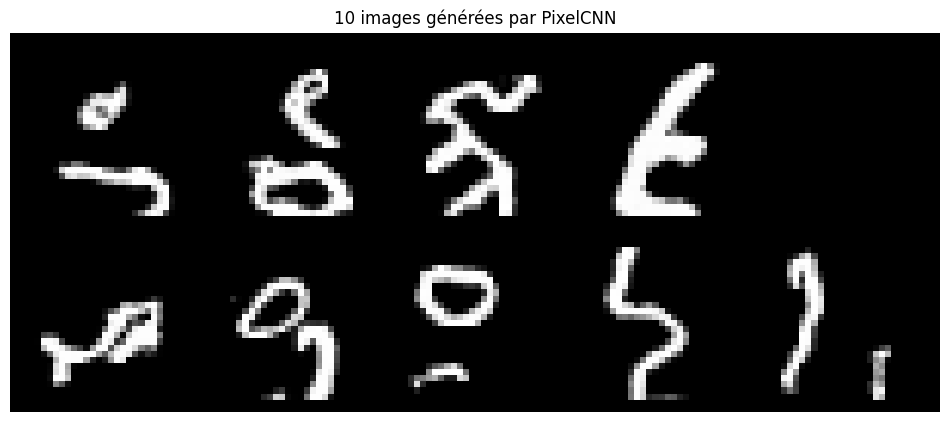

In [136]:
def generate_images(pixelcnn, num_images=10, size=(28, 28)):
    # Initialiser un tenseur pour stocker toutes les images
    images = torch.zeros((num_images, 1, size[0], size[1])).to(device)
    
    # Générer chaque pixel pour toutes les images en parallèle
    for i in range(size[0]):
        for j in range(size[1]):
            with torch.no_grad():
                # Passer toutes les images en même temps
                output = pixelcnn(images)
                # Extraire les probabilités pour le pixel (i, j) de chaque image
                probs = F.softmax(output[:, :, i, j], dim=1)
                # Échantillonner un pixel pour chaque image
                pixels = torch.multinomial(probs, 1).float() / 255
                # Assigner les pixels générés à la position (i, j) dans chaque image
                images[:, 0, i, j] = pixels.squeeze()
    
    return images

# Générer 10 images
num_images = 10
generated_images = generate_images(net, num_images=num_images)

# Afficher les images dans une grille
plt.figure(figsize=(12, 6))
plt.title(f"{num_images} images générées par PixelCNN")
plt.imshow(make_grid(generated_images.cpu(), nrow=5).permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()



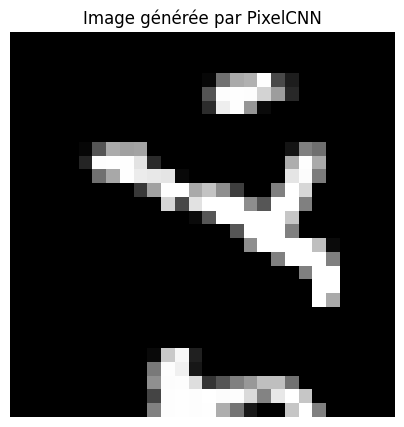

In [137]:
def generate_image(pixelcnn, image_size=(28, 28), num_channels=1, device=device):
    # Initialiser une image vide
    image = torch.zeros((1, num_channels, *image_size), device=device)
    
    # Générer chaque pixel de l'image
    for i in range(image_size[0]):
        for j in range(image_size[1]):
            with torch.no_grad():
                # Passer l'image partiellement remplie à travers le modèle
                output = pixelcnn(image)
                # Extraire les probabilités pour le pixel (i, j)
                probs = F.softmax(output[:, :, i, j], dim=1)
                # Échantillonner un pixel selon les probabilités
                pixel_value = torch.multinomial(probs, 1).float() / 255
                # Assigner la valeur échantillonnée au pixel (i, j)
                image[:, :, i, j] = pixel_value.squeeze()
    
    return image

# Générer une image
generated_image = generate_image(net)

# Afficher l'image générée
plt.figure(figsize=(5, 5))
plt.title("Image générée par PixelCNN")
plt.imshow(generated_image.squeeze().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

---
### **Conclusion du TP 4.1 - Auto-encodeurs variationnels et TP 4.2 - VAE conditionnel et PixelCNN**

Ce TP a permis d'explorer deux modèles génératifs puissants : les **auto-encodeurs variationnels (VAE)** et les **PixelCNN**. Voici un résumé des points clés et des apprentissages :

---

#### **1. Auto-encodeurs variationnels (VAE)**
- **Objectif** : Apprendre un espace latent continu pour générer des données synthétiques plausibles.
- **Implémentation** :
  - L'encodeur produit une distribution gaussienne dans l'espace latent (`mu` et `logvar`).
  - Le décodeur reconstruit les données à partir de l'espace latent.
  - La reparamétrisation permet d'échantillonner dans l'espace latent tout en restant différentiable.
- **Résultats** :
  - Le VAE est capable de reconstruire des images avec une qualité raisonnable.
  - Il permet de générer de nouvelles images en échantillonnant dans l'espace latent.
  - L'interpolation dans l'espace latent produit des transitions fluides entre différentes images.
- **Limites** :
  - Les reconstructions peuvent manquer de détails par rapport à un auto-encodeur classique.
  - La qualité des générations dépend fortement du poids de la divergence de Kullback-Leibler (`β`).

---

#### **2. VAE conditionnel**
- **Objectif** : Générer des images conditionnées à une étiquette (par exemple, un chiffre spécifique dans MNIST).
- **Implémentation** :
  - Le conditionnement est ajouté sous forme de vecteurs one-hot concaténés aux features de l'encodeur et du décodeur.
  - Le modèle apprend à générer des images en fonction de l'étiquette fournie.
- **Résultats** :
  - Le VAE conditionnel génère des images correspondant aux étiquettes spécifiées.
  - Il permet de contrôler la génération en fonction de classes prédéfinies.

---

#### **3. PixelCNN**
- **Objectif** : Modéliser la distribution des pixels d'une image de manière autorégressive.
- **Implémentation** :
  - Utilisation de convolutions masquées pour respecter l'ordre de génération des pixels.
  - Le modèle prédit la distribution de chaque pixel conditionnellement aux pixels précédents.
- **Résultats** :
  - PixelCNN génère des images pixel par pixel, en respectant les dépendances spatiales.
  - Les images générées sont cohérentes, bien que le processus soit lent en raison de la nature séquentielle du modèle.
- **Limites** :
  - La génération est lente car elle se fait pixel par pixel.
  - Le modèle peut avoir du mal à capturer des structures globales complexes.

---

#### **4. Synthèse des apprentissages**
- **VAE** :
  - Idéal pour apprendre un espace latent continu et générer des données variées.
  - Permet des interpolations fluides et une génération contrôlée via le conditionnement.
- **PixelCNN** :
  - Excellente modélisation des dépendances locales entre pixels.
  - Génération séquentielle précise, mais coûteuse en temps de calcul.
- **Applications** :
  - Les VAE sont utiles pour la génération d'images, la compression et le débruitage.
  - Les PixelCNN sont adaptés pour des tâches nécessitant une modélisation fine des distributions de pixels, comme la génération d'images haute résolution.

---

#### **5. Perspectives**
- **Améliorations possibles** :
  - Utiliser des architectures plus avancées pour le VAE, comme des VAE hiérarchiques ou des VAE avec prior appris.
  - Combiner les avantages des VAE et des PixelCNN pour créer des modèles hybrides.
  - Explorer des techniques d'accélération pour PixelCNN, comme l'utilisation de convolutions parallèles.
- **Applications futures** :
  - Génération de données pour l'entraînement de modèles supervisés.
  - Compression d'images et de vidéos.
  - Art génératif et design assisté par IA.

---

### **Conclusion finale**
Ce TP a permis de comprendre les principes fondamentaux des auto-encodeurs variationnels et des modèles autorégressifs comme PixelCNN. Ces modèles ouvrent la voie à de nombreuses applications en génération de données, en compression et en apprentissage non supervisé. Les compétences acquises ici sont transférables à des problèmes plus complexes et à des domaines variés, comme la vision par ordinateur, le traitement du langage naturel et la synthèse de médias.

---

**KRISSAAN AMEN ALLAH - M2 - TRIED**  
**amenallahkrissane10@gmail.com**  
**amen-allah.krissaan@telecom-sudparis.eu**  
**Lab 4 - DEEP RN**  

---





---